# Correlation Exercises

- Use the telco_churn data. Does tenure correlate with monthly charges? Total charges? What happens if you control for phone and internet service?
- Use the employees database.
    - Is there a relationship between how long an employee has been with the company and their salary?
    - Is there a relationship between how long an employee has been with the company and the number of titles they have had?
- Use the sleepstudy data. Is there a relationship between days and reaction time?

In [17]:
%matplotlib inline
import pandas as pd
import numpy as np
from scipy import stats
import pydataset
import matplotlib.pyplot as plt
import seaborn as sns

import env

url = f'mysql+pymysql://{env.user}:{env.password}@{env.host}/telco_churn'
    
pd.options.display.max_columns = None

In [18]:
df = pd.read_sql(
    'select * from customers join internet_service_types using (internet_service_type_id)',
    url
)
df = df[['tenure', 'monthly_charges', 'total_charges', 'internet_service_type', 'phone_service']]

In [20]:
df.sort_values(by='total_charges').head()

,tenure,monthly_charges,total_charges,internet_service_type,phone_service
2855,0,73.35,,DSL,Yes
3118,0,52.55,,DSL,No
3052,0,25.75,,None,Yes
5433,0,19.85,,None,Yes
1731,0,20.00,,None,Yes


In [22]:
# .loc[row index, column(s)]
df.loc[2855, 'total_charges']

' '

In [24]:
df.total_charges = df.total_charges.replace(' ', np.nan).astype(float)

In [25]:
df.isna().mean()

tenure                   0.000000
monthly_charges          0.000000
total_charges            0.001562
internet_service_type    0.000000
phone_service            0.000000
dtype: float64

In [26]:
df = df[df.total_charges.notna()]

In [27]:
df.isna().sum()

tenure                   0
monthly_charges          0
total_charges            0
internet_service_type    0
phone_service            0
dtype: int64

- $\alpha$: .05
- $H_0$: there is no linear relationship between tenure and monthly charges
- $H_a$: there is a linear relationship between tenure and monthly charges

In [28]:
stats.pearsonr(df.tenure, df.monthly_charges)

(0.2468617666408953, 3.98982132325287e-98)

We reject the null hypothesis, but the correlation isn't very strong; It seems like tenure and monthly charges aren't linearly correlated.

- $\alpha$: .05
- $H_0$: there is no linear relationship between tenure and total charges
- $H_a$: there is a linear relationship between tenure and total charges

In [29]:
stats.pearsonr(df.tenure, df.total_charges)

(0.8258804609332077, 0.0)

Again we reject the null hypothesis, but here it seems like tenure and total charges are strongly related. This might be expected because as a customer has been with the company longer they have paid the company more in total.

Controlling for subgroups:

In [31]:
def correlate_tenure_and_monthly_charges(df):
    return pd.Series(stats.pearsonr(df.tenure, df.monthly_charges), index=['r', 'p'])

df.groupby(['internet_service_type', 'phone_service']).apply(correlate_tenure_and_monthly_charges)

r              p
internet_service_type phone_service                         
DSL                   No             0.592430   1.173274e-65
                      Yes            0.658094  5.781402e-216
Fiber optic           Yes            0.624621   0.000000e+00
None                  Yes            0.346188   4.896605e-44

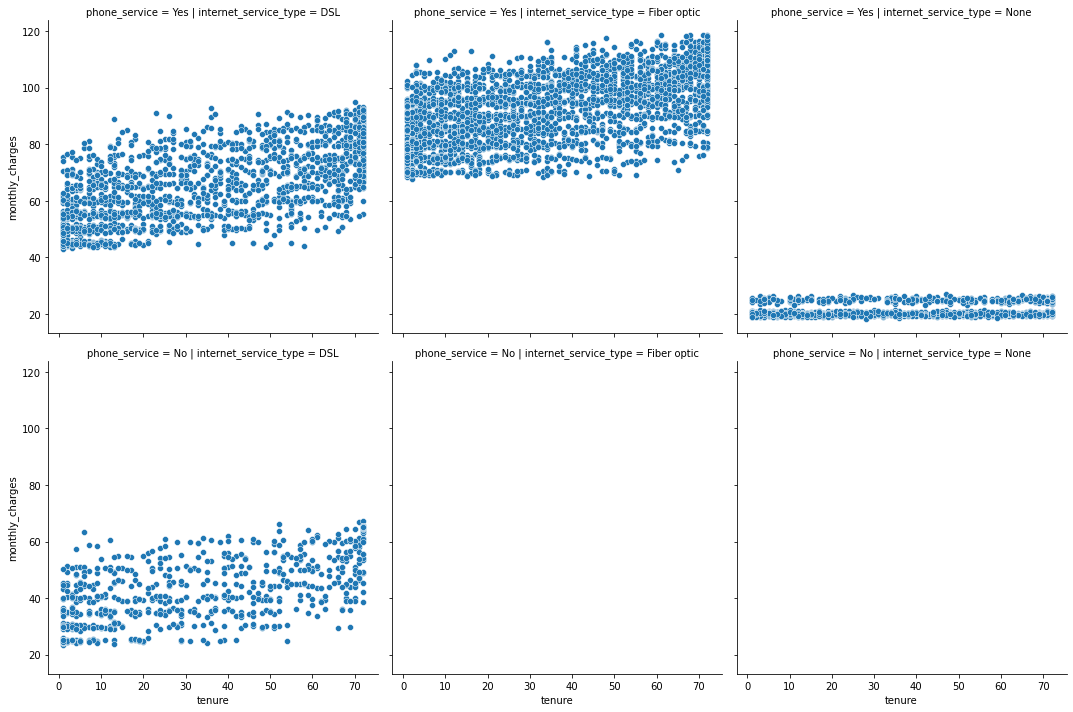

In [35]:
sns.relplot(data=df, y='monthly_charges', x='tenure', col='internet_service_type', row='phone_service')

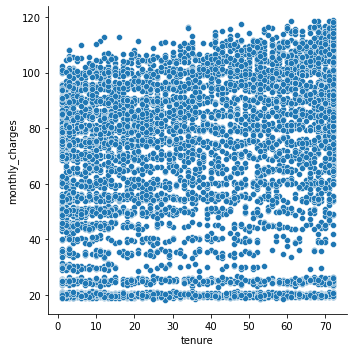

In [63]:
sns.relplot(data=df, y='monthly_charges', x='tenure')

It seems like the correlation is stronger within each subgroup than it is overall! How is this possible?

In [36]:
def correlate_tenure_and_total_charges(df):
    return pd.Series(stats.pearsonr(df.tenure, df.total_charges), index=['r', 'p'])

df.groupby(['internet_service_type', 'phone_service']).apply(correlate_tenure_and_total_charges)

r    p
internet_service_type phone_service               
DSL                   No             0.953423  0.0
                      Yes            0.970533  0.0
Fiber optic           Yes            0.985309  0.0
None                  Yes            0.981465  0.0

In [47]:
x = 123

print(f'{x=}')

x=123


In [45]:
import itertools as it

combos = list(it.product(
    df.internet_service_type.unique().tolist(),
    df.phone_service.unique().tolist(),
))

for internet_service_type, phone_service in combos:
    print(f'{internet_service_type=}, {phone_service=}')

internet_service_type='DSL', phone_service='Yes'
internet_service_type='DSL', phone_service='No'
internet_service_type='Fiber optic', phone_service='Yes'
internet_service_type='Fiber optic', phone_service='No'
internet_service_type='None', phone_service='Yes'
internet_service_type='None', phone_service='No'


---

In [3]:
url = f'mysql+pymysql://{env.user}:{env.password}@{env.host}/employees'

query = '''
SELECT
    DATEDIFF((SELECT MAX(hire_date) FROM employees), e.hire_date) AS tenure,
    s.salary AS salary
FROM employees e
JOIN salaries s USING (emp_no)
WHERE s.to_date > NOW()
'''

employees_with_salaries = pd.read_sql(query, url)

In [49]:
employees_with_salaries.head()

,tenure,salary
0,4964,88958
1,5181,72527
2,4901,43311
3,4806,74057
4,3790,94692


In [51]:
employees_with_salaries.shape

(240124, 2)

- $H_0$: There is no linear relationship between employee tenure and their salary
- $H_a$: There is a linear relationship between employee tenure and their salary

In [50]:
stats.pearsonr(employees_with_salaries.tenure, employees_with_salaries.salary)

(0.30646256131860894, 0.0)

We reject the null hypothesis, however the correlation isn't all that strong.

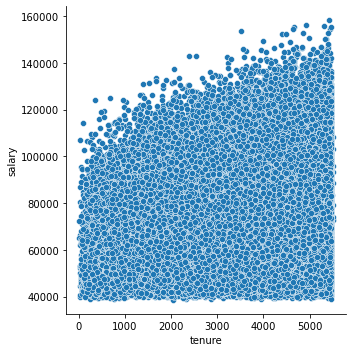

In [52]:
sns.relplot(data=employees_with_salaries, y='salary', x='tenure')

In [ ]:
query = '''
SELECT
    e.emp_no,
    DATEDIFF((SELECT MAX(hire_date) FROM employees), e.hire_date) AS tenure,
    n_titles
FROM employees e
JOIN (
    SELECT emp_no, COUNT(*) as n_titles
    FROM employees e
    JOIN titles t USING (emp_no)
    GROUP BY emp_no
) emp_title_count USING (emp_no)
'''

In [4]:
# CTE
query = '''
WITH emp_title_count AS (
    SELECT emp_no, COUNT(*) as n_titles
    FROM employees e
    JOIN titles t USING (emp_no)
    GROUP BY emp_no
)
SELECT
    e.emp_no,
    DATEDIFF((SELECT MAX(hire_date) FROM employees), e.hire_date) AS tenure,
    n_titles
FROM employees e
JOIN emp_title_count USING (emp_no)
'''

employees_with_titles = pd.read_sql(query, url)

In [55]:
employees_with_titles.shape

(300024, 3)

In [54]:
employees_with_titles.head()

,emp_no,tenure,n_titles
0,10001,4964,1
1,10002,5181,1
2,10003,4901,1
3,10004,4806,2
4,10005,3790,2


- $H_0$: There's no linear relationship between employee tenure and number of titles
- $H_a$: There is a linear relationship between employee tenure and number of titles

In [56]:
stats.pearsonr(employees_with_titles.tenure, employees_with_titles.n_titles)

(0.2665989299136427, 0.0)

We reject the null hypothesis that there is no linear relationship between employee tenure and number of titles.

## Sleep Study

In [60]:
pydataset.data('sleepstudy', show_doc=True)

sleepstudy

PyDataset Documentation (adopted from R Documentation. The displayed examples are in R)

## Reaction times in a sleep deprivation study

### Description

The average reaction time per day for subjects in a sleep deprivation study.
On day 0 the subjects had their normal amount of sleep. Starting that night
they were restricted to 3 hours of sleep per night. The observations represent
the average reaction time on a series of tests given each day to each subject.

### Format

A data frame with 180 observations on the following 3 variables.

`Reaction`

Average reaction time (ms)

`Days`

Number of days of sleep deprivation

`Subject`

Subject number on which the observation was made.

### Details

These data are from the study described in Belenky et al. (2003), for the
sleep-deprived group and for the first 10 days of the study, up to the
recovery period.

### References

Gregory Belenky, Nancy J. Wesensten, David R. Thorne, Maria L. Thomas, Helen
C. Sing, Daniel P. Redmond, 

In [59]:
sleep = pydataset.data('sleepstudy')
sleep.head()

,Reaction,Days,Subject
1,249.5600,0,308
2,258.7047,1,308
3,250.8006,2,308
4,321.4398,3,308
5,356.8519,4,308


- $H_0$: there is no linear relationship between reaction time and number of days
- $H_a$: there is a linear relationship between reaction time and number of days

In [61]:
stats.pearsonr(sleep.Reaction, sleep.Days)

(0.5352302262650254, 9.89409632221453e-15)

We reject the null hypothesis that there is no relationship betwee reaction time and number of days.

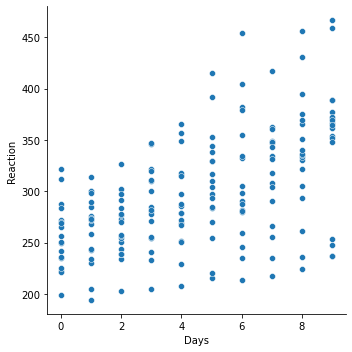

In [62]:
sns.relplot(data=sleep, y='Reaction', x='Days')